In [1]:
import pypsa
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def plot_network(network):
    # Convert PyPSA network to a NetworkX graph
    G = nx.Graph()

    # Add nodes with attributes
    for bus in network.buses.index:
        load = network.loads[network.loads["bus"] == bus]["p_set"].sum()
        generators = network.generators[network.generators["bus"] == bus]["p_nom"].sum()
        G.add_node(bus, pos=(network.buses.loc[bus, "x"], network.buses.loc[bus, "y"]), load=load, generators=generators)

    # Add edges
    for line in network.lines.index:
        G.add_edge(network.lines.loc[line, "bus0"],
                network.lines.loc[line, "bus1"],
                weight=network.lines.loc[line, "length"])

    # Extract positions for nodes
    positions = nx.get_node_attributes(G, "pos")
    loads = nx.get_node_attributes(G, "load")
    generators = nx.get_node_attributes(G, "generators")

    # Draw the graph
    plt.figure(figsize=(10, 7))

    # Draw edges
    nx.draw(
        G,
        pos=positions,
        with_labels=True,
        node_color="lightblue",
        edge_color="gray",
        node_size=700,
        font_size=10,
        font_color="white",
    )

    # Draw loads as red balls and dotted lines
    for node, (x, y) in positions.items():
        load_value = loads[node]
        if load_value > 0:  # Only draw if there's a load
            # Offset position for the load
            load_x, load_y = x - 0.05, y - 0.2

            # Draw the load as a red ball
            plt.scatter(
                load_x, load_y,
                s=50,  # Size of the ball
                color="red"
            )

            # Draw a dotted line connecting the bus to the load
            plt.plot(
                [x, load_x], [y, load_y],
                linestyle="dotted",
                color="black",
                linewidth=1
            )

    # Draw generators as green triangles and dotted lines
    for node, (x, y) in positions.items():
        generator_value = generators[node]
        if generator_value > 0:  # Only draw if there's a generator
            # Offset position for the generator
            gen_x, gen_y = x + 0.0, y + 0.3

            # Draw the generator as a green triangle
            plt.scatter(
                gen_x, gen_y,
                s=300,  # Size of the triangle
                color="green",
                marker="^"  # Triangle marker
            )

            # Draw a dotted line connecting the bus to the generator
            plt.plot(
                [x, gen_x], [y, gen_y],
                linestyle="dotted",
                color="black",
                linewidth=1
            )

    # Add legend for loads and generators
    handles = [
        plt.Line2D([0], [0], marker="o", color="red", label="Load", markersize=6, linestyle="None"),
        plt.Line2D([0], [0], marker="^", color="green", label="Generator", markersize=8, linestyle="None")
    ]
    plt.legend(handles=handles, loc="upper right")

    plt.title("PyPSA Network with Loads and Generators")
    plt.show()

In [3]:
# Example of simplified setup
network = pypsa.Network()
network.set_snapshots(["2024-01-01 00:00"])

# Add one bus and one generator
network.add("Bus", "Bus 1", v_nom=110, x=0, y=0, carrier="electricity")
network.add("Generator", "Generator 1", bus="Bus 1", p_nom=100, marginal_cost=60, carrier="thermal")
network.add("Load", "Load 1", bus="Bus 1", p_set=50)

# Run optimization
network.optimize()

Index(['Generator 1'], dtype='object', name='Generator')
Index(['Bus 1'], dtype='object', name='Bus')
Index(['Generator 1'], dtype='object', name='Generator')
Index(['Bus 1'], dtype='object', name='Bus')
/opt/homebrew/Caskroom/miniforge/base/envs/mesh_viz/lib/python3.13/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1 primals, 3 duals
Objective: 3.00e+03
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+01, 6e+01]
  Bound  [0e+00, 0e+00]
  RHS    [5e+01, 1e+02]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-3); columns 0(-1); elements 0(-3) - Reduced to empty
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-6doqjbj0
Model status        : Optimal
Objective value     :  3.0000000000e+03
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/lp/xy_zbssn7fsggx2qw998gl7c0000gn/T/linopy-solve-pnn0m9zx.sol


('ok', 'optimal')

In [14]:
# Create a new PyPSA network
network = pypsa.Network()
# Set the snapshot time (can be expanded for multiple time steps)
network.set_snapshots(["2024-01-01 00:00"])

# Add carriers
network.add("Carrier", "electricity")
network.add("Carrier", "thermal")

# Add buses (nodes)
for i in range(5):
    network.add("Bus", f"Bus {i+1}",
                v_nom=110,  # Nominal voltage in kV
                x=0, y=i,   # Dummy coordinates for visualization
                carrier="electricity")  
    
# Add lines to form a mesh network
lines = [
    ("Bus 1", "Bus 2"),
    ("Bus 1", "Bus 3"),
    ("Bus 2", "Bus 4"),
    ("Bus 3", "Bus 5"),
    ("Bus 4", "Bus 5"),
    ("Bus 1", "Bus 4"),
    ("Bus 2", "Bus 5"),
]

for i, (bus0, bus1) in enumerate(lines):
    network.add("Line", f"Line {i+1}",
                bus0=bus0,
                bus1=bus1,
                length=100,  # Length in km
                r=0.1,       # Resistance per km
                x=0.4,       # Reactance per km
                c=0.01,      # Capacitance per km
                carrier="electricity")
    
# Add generators at two buses
generators = [("Bus 1", 200), ("Bus 3", 200)]  # (bus, p_nom)
for i, (bus, p_nom) in enumerate(generators):
    network.add("Generator", f"Generator {i+1}",
                bus=bus,
                p_nom=p_nom,    # Nominal power in MW
                marginal_cost=50,  # Cost per MWh
                carrier="thermal")
    

# Add loads at all buses
for i in range(5):
    network.add("Load", f"Load {i+1}",
                bus=f"Bus {i+1}",
                p_set=10)  # Set load in MW
    
# Set dummy coordinates for the buses (latitude and longitude)
coordinates = {
    "Bus 1": (0, 0),
    "Bus 2": (1, 1),
    "Bus 3": (2, 0),
    "Bus 4": (1, -1),
    "Bus 5": (2, -2),
}
for bus, (x, y) in coordinates.items():
    network.buses.loc[bus, "x"] = x
    network.buses.loc[bus, "y"] = y

In [15]:
network.optimize()

and branches. Passive flows are not allowed for non-electric networks!
/opt/homebrew/Caskroom/miniforge/base/envs/mesh_viz/lib/python3.13/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: infeasible



Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [8e-01, 1e+00]
  Cost   [5e+01, 5e+01]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 2e+02]
Presolving model
Problem status detected on presolve: Infeasible
Model name          : linopy-problem-1vlcvtjy
Model status        : Infeasible
Objective value     :  0.0000000000e+00
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/lp/xy_zbssn7fsggx2qw998gl7c0000gn/T/linopy-solve-j5w4ywvm.sol


('warning', 'infeasible')

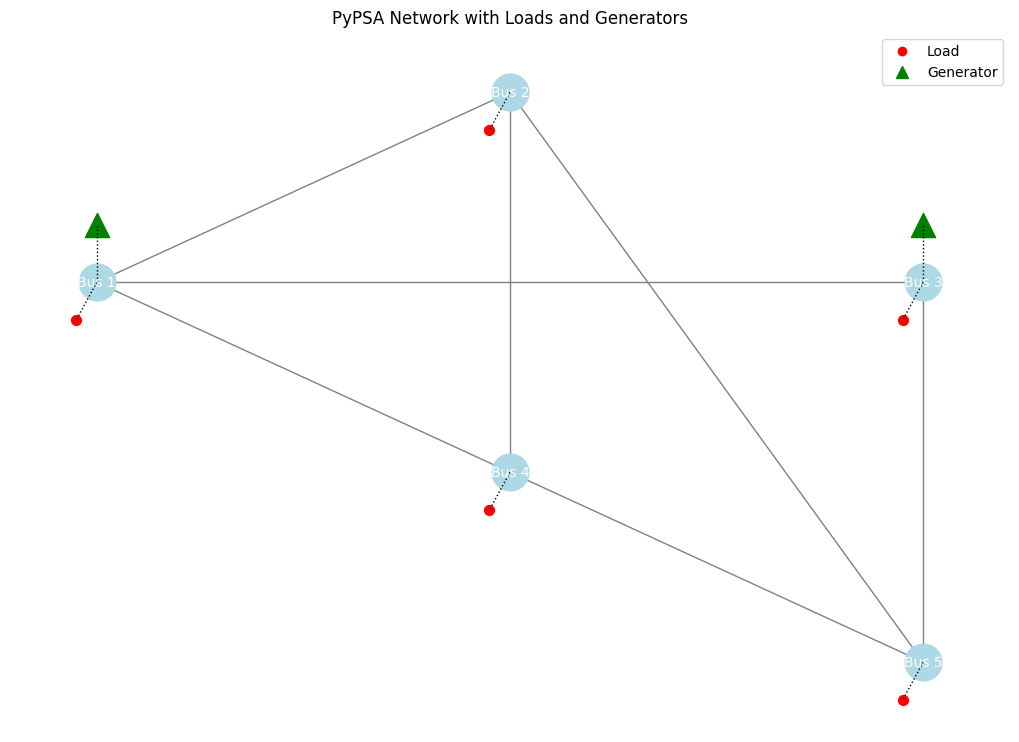

In [4]:
plot_network(network)

In [11]:
# Output the network to verify
print(network)

PyPSA Network
Components:
 - Bus: 5
 - Generator: 2
 - Line: 7
 - Load: 5
Snapshots: 1


In [5]:
network.model

AttributeError: 'Network' object has no attribute 'model'

In [12]:
# Solve the network's optimal power flow (OPF)
network.lpf(network.snapshots)

INFO:pypsa.pf:Performing linear load-flow on AC sub-network <pypsa.components.SubNetwork object at 0x12e83b0e0> for snapshot(s) Index(['2024-01-01 00:00'], dtype='object', name='snapshot')


In [13]:
# Print results for generators and loads
print(network.generators_t.p)  # Generator outputs
print(network.loads_t.p)       # Load power consumptions

Generator         Generator 1  Generator 2
snapshot                                  
2024-01-01 00:00        250.0          0.0
Load              Load 1  Load 2  Load 3  Load 4  Load 5
snapshot                                                
2024-01-01 00:00    50.0    50.0    50.0    50.0    50.0
